In [1]:
import pandas as pd
import numpy as np

import geopandas as gpd
import geoplot as gplt
from shapely.geometry import Point
import geoplot.crs as gcrs

import matplotlib.pyplot as plt
import seaborn as sns

import re

Let us load the tanishq_products.csv and tanishq_event_data.csv into DataFrames

In [2]:
event_df = pd.read_csv('/opt/cs145442/data/yfret/tanishq_event_data.csv')
product_df = pd.read_csv('/opt/cs145442/data/yfret/tanishq_products.csv')

/Users/amitkumarkhetan/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Let's take a peek at Events Dataframe

In [3]:
event_df.head(3)

,action_type,user_type,epoch,object_id,user_id,sid,og_url,tt_id,sub_account,utm_source,utm_campaign,utm_medium,referrer,utm_content,latitude,longitude,useragent,variant_id
0,view,guest,2019-11-28 20:59:00.000,Buy Engagement Rings Online - Shop Diamond Eng...,NaN,0.693364,https://www.tanishq.co.in/shop/engagement-ring...,1574974426476,tanishq,NaN,NaN,NaN,NaN,NaN,26.9167,75.8167,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,NaN
1,view,guest,2019-11-28 20:59:00.000,500064ONAABB09,NaN,0.472003,https://www.tanishq.co.in/product/tanishq-18kt...,1574973022537,tanishq,NaN,NaN,NaN,NaN,NaN,13.0843,80.2805,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,3IH000030
2,view,guest,2019-11-28 20:59:01.000,Buy Diamond Earrings Online in India | Shop La...,NaN,0.897467,https://www.tanishq.co.in/shop/diamond-earring...,1574974640117,tanishq,NaN,NaN,NaN,NaN,NaN,38.9841,-77.3672,Mozilla/5.0 (iPhone; CPU iPhone OS 13_1_3 like...,NaN


* **action_type** is what the user is doing in that current timestamp
* **user_type** is whether is anonymous or logged in
* **epoch** is the timestamp
* **object id** is changes based on the action type Ex. product Id, collection Id etc
  * 17 NaN, will figure out the way to fill this  
* **user_id** is supposed to be user_id, whereas tt_id is also user_id
  * confusing as of now
  * 795511 NaN
* **s_id** is what the session id for which event was recorded
  * no NaN
* **og_url** is what the url for which the event was recorded
  * permalinks will be helpful for further clustering, if needed
* **tt_id** is the assumed to be unique user_id for every individual
  * no NaN
* **sub_account** is 'tanishq' for all the records, will drop this column
* **utm_params** 
  * **utm_source** 763136 NaN
  * **utm_medium** 608639 NaN
  * **utm_campaign** 608639 NaN
  * **utm_content** 797840 NaN
* **referrer** 441725 NaN
* **useragent** is the details of device and clients, we'll break it down
* **variant_id** 474166 NaN, 4831 Unique Variants

In [4]:
# list of major utm_content
# event_df['utm_content'].value_counts().iloc[0:5]

In [5]:
# list of major referrer
# event_df['referrer'].value_counts().sort_values(ascending=False).iloc[0:15]

In [6]:
# Dropping the sub_account
event_df.drop('sub_account', axis=1, inplace=True)

In [7]:
# Converting the epoch to datetime
event_df['epoch'] = pd.to_datetime(event_df['epoch'])

In [8]:
# Dropping the user_id column, tt_id has the user_id records
event_df.drop('user_id', axis=1, inplace=True)

In [9]:
# Extracting valuable informations from the og_url
event_df['og_meta'] = event_df['og_url'].apply(lambda x: ','.join(x.replace('https://www.tanishq.co.in/', '').replace('/', ',').replace('?', ',').replace('&', ',').split(',')))

In [10]:
# Adding two columns to store information such as page_details & product_details

# Page details: ['shop', 'product', 'cart', 'checkout', 'myaccount']
event_df['og_meta_page'] = event_df['og_meta'].apply(lambda x: x.split(',')[0])

# Product details: jewellery, gold-earring, etc.
event_df['og_meta_product'] = event_df['og_meta'].apply(lambda x: x.split(',')[1])

In [21]:
# tt_id of user's who placed order
user_placed_order = event_df[event_df.action_type == 'place_order']['tt_id'].tolist()

In [41]:
# sid of user's who placed order
sid_placed_order = event_df[event_df.action_type == 'place_order']['sid'].tolist()

In [40]:
# Time difference between when user starts viewing and ends up placing the order, for all their sessions
event_df[event_df['tt_id'].isin(user_placed_order)].sort_values(by='epoch', ascending=True).groupby(['tt_id', 'sid']).agg({'epoch': [np.max, np.min]})

epoch                    
                                      amax                amin
tt_id         sid                                             
1556192230670 0.240012 2019-11-30 04:58:54 2019-11-28 07:38:46
              0.255956 2019-11-30 04:56:42 2019-11-30 04:51:46
              0.479870 2019-11-30 05:37:16 2019-11-30 05:37:16
1556635697710 0.814909 2019-11-27 15:53:19 2019-11-27 10:07:41
1556696450282 0.249243 2019-11-28 17:57:23 2019-11-28 17:00:39
...                                    ...                 ...
1575124299742 0.310904 2019-11-30 14:33:50 2019-11-30 14:31:43
1575124390712 0.470990 2019-11-30 15:30:02 2019-11-30 14:35:13
1575124500709 0.194445 2019-11-30 14:38:20 2019-11-30 14:35:06
1575124764298 0.414040 2019-11-30 14:41:48 2019-11-30 14:39:39
1575137133986 0.650561 2019-11-30 18:44:38 2019-11-30 18:07:47

[163 rows x 2 columns]

In [48]:
# Time difference between when user starts viewing and ends up placing the order, for only the sessions when they placed the order
event_df_placed_order = event_df[event_df['tt_id'].isin(user_placed_order)]
event_df_placed_order['sid'].isin(sid_placed_order).sort_values(by='epoch', ascending=True).groupby(['tt_id', 'sid']).agg({'epoch': [np.max, np.min]})

TypeError: sort_values() got an unexpected keyword argument 'by'

In [33]:
# Looking at the user activity for the tt_id '1575137133986'
event_df[event_df['tt_id'].isin([1575137133986])].sort_values(by='epoch', ascending=True)

,action_type,user_type,epoch,object_id,sid,og_url,tt_id,utm_source,utm_campaign,utm_medium,referrer,utm_content,latitude,longitude,useragent,variant_id,og_meta,og_meta_page,og_meta_product
781852,view,guest,2019-11-30 18:07:47,Buy Platinum Pendant Online | Platinum Pendant...,0.650561,https://www.tanishq.co.in/shop/platinum-pendants,1575137133986,NaN,NaN,NaN,NaN,NaN,18.5332,73.8626,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,NaN,"shop,platinum-pendants",shop,platinum-pendants
782415,view,guest,2019-11-30 18:09:02,Buy Gold,0.650561,https://www.tanishq.co.in/shop/jewellery?sort=...,1575137133986,NaN,NaN,NaN,NaN,NaN,18.5332,73.8626,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,NaN,"shop,jewellery,sort=10,page=3",shop,jewellery
782497,view,guest,2019-11-30 18:09:33,Buy Gold,0.650561,https://www.tanishq.co.in/shop/jewellery?sort=...,1575137133986,NaN,NaN,NaN,NaN,NaN,18.5332,73.8626,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,NaN,"shop,jewellery,sort=10,page=4",shop,jewellery
782560,view,guest,2019-11-30 18:09:53,Buy Gold,0.650561,https://www.tanishq.co.in/shop/jewellery?sort=...,1575137133986,NaN,NaN,NaN,NaN,NaN,18.5332,73.8626,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,NaN,"shop,jewellery,sort=10,page=5",shop,jewellery
782846,view,guest,2019-11-30 18:10:21,Buy Gold,0.650561,https://www.tanishq.co.in/shop/jewellery?sort=...,1575137133986,NaN,NaN,NaN,NaN,NaN,18.5332,73.8626,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,NaN,"shop,jewellery,sort=10,page=6",shop,jewellery
782962,view,guest,2019-11-30 18:10:58,Buy Gold,0.650561,https://www.tanishq.co.in/shop/jewellery?sort=...,1575137133986,NaN,NaN,NaN,NaN,NaN,18.5332,73.8626,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,NaN,"shop,jewellery,sort=10,page=7",shop,jewellery
783045,view,guest,2019-11-30 18:11:30,Buy Gold,0.650561,https://www.tanishq.co.in/shop/jewellery?sort=...,1575137133986,NaN,NaN,NaN,NaN,NaN,18.5332,73.8626,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,NaN,"shop,jewellery,sort=10,page=8",shop,jewellery
783128,view,guest,2019-11-30 18:11:58,501718FENLAA29,0.650561,https://www.tanishq.co.in/product/tanishq-18kt...,1575137133986,NaN,NaN,NaN,NaN,NaN,18.5332,73.8626,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2JA000075,"product,tanishq-18kt-rose-gold-ruby-and-diamon...",product,tanishq-18kt-rose-gold-ruby-and-diamond-finger...
783456,view,guest,2019-11-30 18:12:50,Buy Gold,0.650561,https://www.tanishq.co.in/shop/jewellery?sort=...,1575137133986,NaN,NaN,NaN,NaN,NaN,18.5332,73.8626,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,NaN,"shop,jewellery,sort=10,page=9",shop,jewellery
784065,view,guest,2019-11-30 18:13:32,Buy Gold,0.650561,https://www.tanishq.co.in/shop/jewellery/price...,1575137133986,NaN,NaN,NaN,NaN,NaN,18.5332,73.8626,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,NaN,"shop,jewellery,price=10000-20000,gender=women,...",shop,jewellery


### Let's take a peek at the Product DataFrame

In [18]:
product_df.columns

Index(['_id', 'additional_image', 'adult', 'availability_date', 'avlble',
       'brand', 'business_unit', 'category', 'collection', 'color',
       'condition', 'created_on', 'currency', 'currency_symbol', 'description',
       'diamond_clarity', 'diamond_color', 'diamond_cut',
       'discount_percentage', 'expiration_date', 'full_description',
       'gemstone1', 'gemstone2', 'gemstone3', 'gemstone4', 'gemstone5',
       'gender', 'goldkaratage', 'google_product_category', 'gtin', 'height',
       'id', 'identifier_exists', 'image', 'item_group_id', 'jew_size',
       'jewellery_type', 'last_modified_on', 'listprice', 'metal',
       'metal_color', 'mfr_code', 'mpn', 'name', 'occasion', 'out_of_shelf',
       'price', 'price_usd', 'product', 'product_type', 'sale_price_usd',
       'status', 'sub_account', 'subcategories', 'trendrank', 'unit',
       'updated', 'url', 'variants', 'width'],
      dtype='object')

In [16]:
collision_points = data.apply(
    lambda srs: Point(float(srs['longitude']), float(srs['latitude'])),
    axis='columns'
)
collision_points

0                  POINT (75.8167 26.9167)
1                  POINT (80.2805 13.0843)
2                 POINT (-77.3672 38.9841)
3                  POINT (75.8167 26.9167)
4                     POINT (76.2667 32.1)
                        ...               
801805             POINT (73.8626 18.5332)
801806             POINT (78.3437 16.9917)
801807             POINT (77.0309 28.4666)
801808    POINT (76.28449999999999 9.9819)
801809             POINT (77.0309 28.4666)
Length: 801810, dtype: object

In [17]:
data_geocoded = gpd.GeoDataFrame(data, geometry=collision_points)

In [18]:
data_geocoded.head()

,action_type,user_type,epoch,object_id,user_id,sid,og_url,tt_id,sub_account,utm_source,utm_campaign,utm_medium,referrer,utm_content,latitude,longitude,useragent,variant_id,geometry
0,view,guest,2019-11-28 20:59:00.000,Buy Engagement Rings Online - Shop Diamond Eng...,NaN,0.693364,https://www.tanishq.co.in/shop/engagement-ring...,1574974426476,tanishq,NaN,NaN,NaN,NaN,NaN,26.9167,75.8167,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,NaN,POINT (75.81670 26.91670)
1,view,guest,2019-11-28 20:59:00.000,500064ONAABB09,NaN,0.472003,https://www.tanishq.co.in/product/tanishq-18kt...,1574973022537,tanishq,NaN,NaN,NaN,NaN,NaN,13.0843,80.2805,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,3IH000030,POINT (80.28050 13.08430)
2,view,guest,2019-11-28 20:59:01.000,Buy Diamond Earrings Online in India | Shop La...,NaN,0.897467,https://www.tanishq.co.in/shop/diamond-earring...,1574974640117,tanishq,NaN,NaN,NaN,NaN,NaN,38.9841,-77.3672,Mozilla/5.0 (iPhone; CPU iPhone OS 13_1_3 like...,NaN,POINT (-77.36720 38.98410)
3,view,guest,2019-11-28 20:59:01.000,511250PGUAAA00,NaN,0.403961,https://www.tanishq.co.in/product/tanishq-22kt...,1564659331282,tanishq,NaN,Sok_Traffic_MultipleAds_Prospecting_Tanishq_No...,cpc,m.facebook.com,NaN,26.9167,75.8167,Mozilla/5.0 (Linux; Android 8.1.0; Redmi Note ...,2ED000494,POINT (75.81670 26.91670)
4,view,guest,2019-11-28 20:59:01.000,502112FHHLAJ54,NaN,0.961382,https://www.tanishq.co.in/product/tanishq-18kt...,1574974721184,tanishq,NaN,NaN,NaN,NaN,NaN,32.1000,76.2667,Mozilla/5.0 (iPhone; CPU iPhone OS 13_1_2 like...,3IH000001,POINT (76.26670 32.10000)


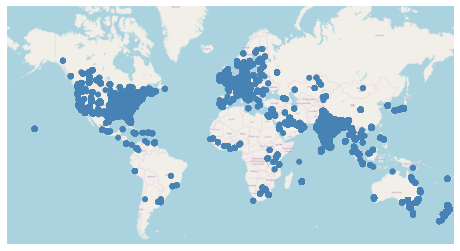

In [29]:
ax = gplt.webmap(data_geocoded, projection=gcrs.WebMercator())
gplt.pointplot(data_geocoded, ax=ax)

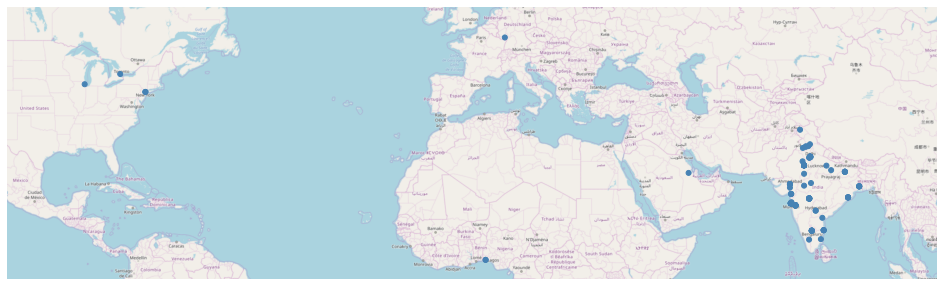

In [102]:
ax2 = gplt.webmap(data_geocoded[data_geocoded.action_type == 'place_order'], projection=gcrs.WebMercator(), figsize=(20,5))
gplt.pointplot(data_geocoded[data_geocoded.action_type == 'place_order'], ax=ax2)
# Scatter plot for regions where orders were placed

  * Out of **139** user's who placed order, __133 were from INDIA__

In [88]:
data = data.fillna('NA')

In [89]:
data_placed_order = data[data.action_type == 'place_order']

In [98]:
print(data_placed_order['utm_source'].value_counts())
print(data_placed_order['utm_medium'].value_counts())
print(data_placed_order['utm_campaign'].value_counts())

NA    136
Name: utm_source, dtype: int64
NA    136
Name: utm_medium, dtype: int64
NA    136
Name: utm_campaign, dtype: int64


  * Users who placed the order had **NO UTM Parameters**

In [99]:
data_placed_order['referrer'].value_counts()

NA                134
m.facebook.com      2
Name: referrer, dtype: int64

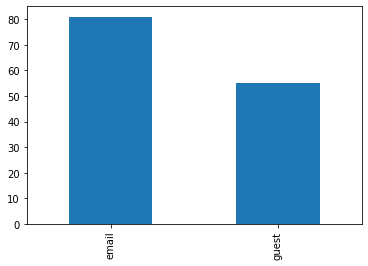

In [101]:
data_placed_order['user_type'].value_counts().plot(kind='bar')

In [115]:
# What is the hypothesis?
# Goal is to find the list of buyers who came from which utm_source
data[data['sid'].isin(data_placed_order['sid'].tolist())].groupby('tt_id').action_type.value_counts()

tt_id          action_type     
1556192230670  place_order          1
1556635697710  view                10
               add_to_cart          2
               place_order          1
1556696450282  view                21
                                   ..
1575124764298  view                 1
1575137133986  view                26
               add_to_cart          1
               place_order          1
               remove_from_cart     1
Name: action_type, Length: 331, dtype: int64

In [121]:
data[data['sid'].isin(data_placed_order['sid'].tolist())]['utm_source'].value_counts()

NA           1791
yfret          29
criteo         11
FBTanishq       8
Name: utm_source, dtype: int64

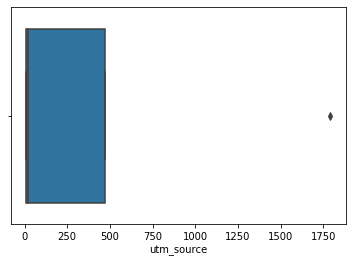

In [123]:
sns.boxplot()